# Districts of Budapest

<img style="width: 100%;" src="DDM.jpg" />

_Stephen Sipos_  
_2020.04.23_

This is my final capstone project for IBM Applied Data Science Capstone course on Coursera.

## Introduction

Budapest which is capital & largest city of Hungary is split by River Danube in two parts: Buda and Pest. It's 23 districts (kerület in Hungarian) are numbered clockwise, in widening circles and marked with Roman numerals (I-XXIII).

Our (imaginary) business provides consulting services for entrepreneurs and investors, who are looking into opening their own businesses here.

After assessing our customers needs we would like to be able to recommend areas, districts to open their shop or service, where their initiative is most like to succeed. In support of this task, we would like to measure and segment the districts based on multiple criteria: average business space rental fee, population density and the most common venues in the area. The last one is the topic of this notebook.

In [16]:
import os
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
import json
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from jinja2 import Template

## The data

### List of districts:

Of course, we could just list the roman numerals from I. to XXIII. to build our initial database, but instead we are going to query [Wikipedia](https://en.wikipedia.org/wiki/List_of_districts_in_Budapest), since the web-page contains other useful information, which we could use later in our investigations.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_in_Budapest'
df = pd.read_html(url)[1]

# drop the Sum row

df = df[df['District'].str.contains('kerület')]

# A quick look at the data
df.head()

,District,Name,Population (2016),Area (km2),Population density (people per km2)
0,I. kerület,"Várkerület (""Castle District"")",25196,3.41,7388.8
1,II. kerület,-,89903,36.34,2473.9
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",130415,39.70,3285.0
3,IV. kerület,"Újpest (""New Pest"")",101558,18.82,5396.2
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",26284,2.59,10148.2


In [3]:
df.shape

(23, 5)

District name, population and area are not important for us.

In [4]:
df.drop(columns=['Name', 'Population (2016)', 'Area (km2)'], inplace = True)
df.rename(columns={'Population density (people per km2)': 'Population density'}, inplace=True)

df.head()

,District,Population density
0,I. kerület,7388.8
1,II. kerület,2473.9
2,III. kerület,3285.0
3,IV. kerület,5396.2
4,V. kerület,10148.2


### Most common venues

The get the most common venue types, we are going to utilize the [Foursquare Places API](https://foursquare.com). It enables us to access and query the foursqare database, which is considered one of the fullest location data platform on the scene.  

We will be using the geographical location data (latitude and longitude) for map visualization, and the venue class to categorize the individual districts.

One way to query the foursquare database is to have geographical coordinates, but in this case we are simply ask for addresses in the request. Specifying "Budapest, III. kerület" int the query string will result foursqaure to correctly return venues from the III. district.

#### Querying foursquare

In [5]:
def get_url(endpoint, **argv):
    """
    Builds the API endpoint url by adding aythentication credentials,
    and passed parameters to the query
    """
    api_endpoint = {
        'explore': "https://api.foursquare.com/v2/venues/explore?",
        'search': "https://api.foursquare.com/v2/venues/search?",
        #Add more if needed
    }[endpoint]

    credentials = {
        'client_id': os.environ['FOURSQUARE_CLIENT_ID'],
        'client_secret': os.environ['FOURSQUARE_CLIENT_SECRET'],
        'v': '20200411',
    }
    
    url = api_endpoint + urlencode({**credentials, **argv})
    
    return url


def query_district(district_name, venue_data):
    """
    Query one dristrict. This method stores it result in the venue_data
    parameter as a side effect
    """
    print('Getting venues for: ' + district_name)
    url = get_url('explore', near='Budapest, ' + district_name, limit=50)
    
    results = requests.get(url).json()
    
    for item in results['response']['groups'][0]['items']:
        venue = item['venue']
        venue_data.append((
            district_name,
            venue['name'],
            venue['location']['lat'],
            venue['location']['lng'],
            venue['categories'][0]['name'],
        ))
        
def get_foursquare_data(districts):
    """
    calls and aggregates the venue data for each district in the passed list
    """
    venue_data = []
    for district in districts:
        query_district(district, venue_data)
        
    venue_df = pd.DataFrame(venue_data)
    venue_df.columns = ["District", "Name", "Latitude", "Longitude", "Category"]
    
    return venue_df

Execute the query

In [8]:
venues = get_foursquare_data(df['District'])

Getting venues for: I. kerület
Getting venues for: II. kerület
Getting venues for: III. kerület
Getting venues for: IV. kerület
Getting venues for: V. kerület
Getting venues for: VI. kerület
Getting venues for: VII. kerület
Getting venues for: VIII. kerület
Getting venues for: IX. kerület
Getting venues for: X. kerület
Getting venues for: XI. kerület
Getting venues for: XII. kerület
Getting venues for: XIII. kerület
Getting venues for: XIV. kerület
Getting venues for: XV. kerület
Getting venues for: XVI. kerület
Getting venues for: XVII. kerület
Getting venues for: XVIII. kerület
Getting venues for: XIX. kerület
Getting venues for: XX. kerület
Getting venues for: XXI. kerület
Getting venues for: XXII. kerület
Getting venues for: XXIII. kerület


In [9]:
print(venues.shape)
venues.head()

(1150, 5)


,District,Name,Latitude,Longitude,Category
0,I. kerület,Budavári Palota,47.496198,19.039543,Castle
1,I. kerület,Zhao Zhou Teashop & Lab,47.497354,19.041026,Tea Room
2,I. kerület,Magyar Nemzeti Galéria | Hungarian National Ga...,47.496082,19.039468,Art Museum
3,I. kerület,Hotel Clark,47.498507,19.040412,Hotel
4,I. kerület,Várhegy,47.497570,19.038747,Scenic Lookout


A quick peek into the result shows, that we have plenty of venue data to work with.

## Methodology

#### Find the city center, for map visualization

In [10]:
budapest_center = {
    'Latitude': (venues['Latitude'].min() + venues['Latitude'].max())/2,
    'Longitude': (venues['Longitude'].min() + venues['Longitude'].max())/2,
}
zoom_start=11

budapest_center


{'Latitude': 47.46947086504526, 'Longitude': 19.155755226305104}

### Turning venue data into information

We are transforming the venue categories using one-hot encoding. This will enable us to do numerical calculations on the otherwise categorical data.

In [11]:
onehot = pd.get_dummies(venues[['Category']], prefix="", prefix_sep="")

onehot['District'] = venues['District'] 

# move District column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

# group by district and apply weights
grouped = onehot.groupby('District').mean().reset_index()

grouped[grouped.columns[1:]].sum().describe()

count    212.000000
mean       0.108491
std        0.164463
min        0.020000
25%        0.020000
50%        0.040000
75%        0.100000
max        0.880000
dtype: float64

From the above data, we can infer that the venue types distribution is heavily biassed to smaller values, which means most venues appear only a very few times in the database, adding nothing to our cause. 

My idea here is that I keep the 10 features with the highest standard deviation between districts, since they are most likely to indicate differences between the individual areas. After removing the unnecessary columns, I will normalize the data by rows.

In [12]:
# Drop insignificant venues
to_keep = list(grouped.describe().transpose().nlargest(10, 'std').index)
features = grouped[to_keep]

# Normalize the rest by row
scaled_features = pd.DataFrame(Normalizer().fit_transform(features), index=features.index, columns=features.columns)

### Clustering

Using the K-Means algorithm, we are going to identify similar groups of districts in Budapest, and assign one cluster id to each of them. After some experimenting, I've decided that the most meaningful categorization happens when setting the expected number of clusters to 5.

In [13]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaled_features)

# add clustering labels
districts = pd.concat([grouped[['District']], features], axis=1)
districts.insert(1, 'Cluster', kmeans.labels_)
districts.head()


,District,Cluster,Supermarket,Hotel,Coffee Shop,Hungarian Restaurant,Restaurant,Gym / Fitness Center,Bakery,Grocery Store,Dessert Shop,Beer Garden
0,I. kerület,0,0.00,0.10,0.04,0.06,0.02,0.02,0.00,0.00,0.02,0.00
1,II. kerület,2,0.00,0.02,0.04,0.00,0.04,0.02,0.08,0.00,0.06,0.00
2,III. kerület,1,0.02,0.00,0.02,0.08,0.02,0.06,0.02,0.00,0.02,0.02
3,IV. kerület,2,0.02,0.00,0.04,0.02,0.04,0.06,0.04,0.04,0.08,0.00
4,IX. kerület,3,0.02,0.00,0.06,0.00,0.00,0.02,0.02,0.00,0.04,0.04


### Interpretation

In [21]:
template = """
<table>
    <thead>
        <tr>
            {% for cluster in range(kclusters) %}
            <th>Cluster {{cluster}}</th>
            {% endfor %}
        </tr>
    </thead>
    <tbody>
        <tr>
            {% for cluster in range(kclusters) %}
            <td style="vertical-align: top;">
                <ul>
                    {% for district in districts[districts['Cluster'] == cluster]['District'] %}
                        <li>{{district}}</li>
                    {% endfor %}
                </ul>
            </td>
            {% endfor %}
        </tr>
    </tbody>
</table>
"""
display(HTML(Template(template).render({'districts':districts, 'kclusters': kclusters})))

Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
I. kerület V. kerület VII. kerület,III. kerület X. kerület XIX. kerület XVII. kerület XVIII. kerület XXIII. kerület,II. kerület IV. kerület XII. kerület XIV. kerület XV. kerület XVI. kerület,IX. kerület VI. kerület VIII. kerület XI. kerület XIII. kerület,XX. kerület XXI. kerület XXII. kerület


Lets see for each cluster, what are the most dominant venue types

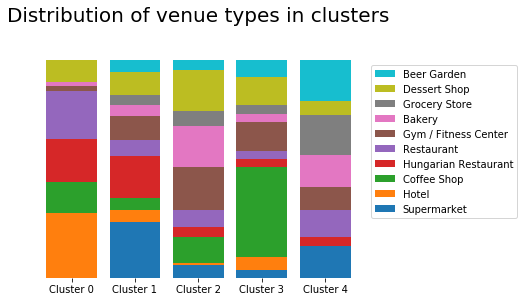

In [17]:
profiles = districts[['Cluster', *to_keep]].groupby('Cluster').sum()
profiles_perc = profiles.divide(profiles.sum(axis=1), axis=0)

ind = np.arange(kclusters) 
width = 0.8
plots = []

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title(label="Distribution of venue types in clusters", fontsize=20)
ttl = ax.title
ttl.set_position([.5, 1.15])

for i in range(len(profiles.columns)):
    plots.append(plt.bar(ind, profiles_perc[profiles.columns[i]], width, bottom=profiles_perc[profiles.columns[:i]].sum(axis=1)))

plt.xticks(ind, (f"Cluster {c}" for c in range(kclusters)))
plt.yticks([], []) # Hide Y ticks
plt.legend((plot[0] for plot in plots[::-1]), profiles.columns[::-1], bbox_to_anchor=(1, 1))
plt.show()

Looking at the above chart, we could guest the 'theme' for the different clusters

In [18]:
clusters = [
    "Hotels and Restaurants", # Business class. Downtown districts
    "Supermarkets and Restaurants", # Central districts
    "Dessert shops, Bakeries and Gym's", # Carbs and regrets
    "Coffee Shops",
    "A little bit of everything" # But mostly beer gardens. Suburban districts
]

## Let's put this on the map

In [20]:

# Array of colors to distinguish each cluster on the map
color_map = [colors.rgb2hex(i) for i in cm.gist_rainbow(np.linspace(0, 1, kclusters))]

# Load tiles for each district
def load_geo_data(districts, df, color_map, clusters):
    """
    Builds a dict of GeoJSON data with geographic coordinates of each district,
    Downloaded from https://data2.openstreetmap.hu/hatarok/index.php?admin=9
    """
    result = {}

    with open('budapest.geojson', 'r') as f:
        geojson = json.load(f)

        for district in geojson['features']:
            name = district['properties']['name']
            result[name] = {
                "type": "FeatureCollection",
                "features": [district],
            }

    # Provide additional data in the geojson properties
    
    for district, cluster in zip(districts['District'], districts['Cluster']):
        result[district]['features'][0]['properties']['Name_En'] = "District " + district.replace(" kerület", "")
        result[district]['features'][0]['properties']['Color'] = color_map[cluster]
        result[district]['features'][0]['properties']['Cluster'] = clusters[cluster]

    for district, population_density in zip(df['District'], df['Population density']):
        result[district]['features'][0]['properties']['PopulationDensity'] = population_density

    return result

geojson = load_geo_data(districts, df, color_map, clusters)

# Create the map
budapest_map = folium.Map(location=[budapest_center['Latitude'], budapest_center['Longitude']], zoom_start=zoom_start)

# Add each district as a geojson object
for district in districts['District']:
    data = geojson[district]
    
    shape = folium.GeoJson(
        data,
        style_function=lambda x: {'fillColor': x['properties']['Color'], 'fillOpacity': 0.7, 'color': 'black', 'weight': 1}
    )
    
    folium.GeoJsonTooltip(
        fields=['Name_En', 'Cluster', 'PopulationDensity'],
        aliases=['Name', 'Cluster', 'Population Density']
    ).add_to(shape)
    
    shape.add_to(budapest_map)

budapest_map

Unsuprisingly, the segmentation shows a concentric pattern.